In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



In [2]:
DATA_DIR = "../data/processed"
MODEL_SAVE_PATH = "../model/model.h5"
LABEL_MAP_PATH = "../model/label_map.json"

IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 30


In [3]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [4]:
label_map = train_generator.class_indices
os.makedirs("../model", exist_ok=True)

with open(LABEL_MAP_PATH, "w") as f:
    json.dump(label_map, f)

print("✅ Label map saved:", label_map)


✅ Label map saved: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [5]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),  # Additional Dropout
    Dense(len(label_map), activation='softmax')
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


C:\Users\creat\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,393,094 (28.20 MB)

 Trainable params: 7,393,094 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath=MODEL_SAVE_PATH, save_best_only=True)
]

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks
)


C:\Users\creat\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - accuracy: 0.2266 - loss: 2.1327

64/64 ━━━━━━━━━━━━━━━━━━━━ 63s 970ms/step - accuracy: 0.2274 - loss: 2.1273 - val_accuracy: 0.2942 - val_loss: 1.5993
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.3838 - loss: 1.4858

64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - accuracy: 0.3842 - loss: 1.4851 - val_accuracy: 0.3439 - val_loss: 1.5482
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.4521 - loss: 1.3526

64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - accuracy: 0.4521 - loss: 1.3523 - val_accuracy: 0.3738 - val_loss: 1.4939
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.4728 - loss: 1.2811

64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 217ms/step - accuracy: 0.4729 - loss: 1.2812 - val_accuracy: 0.4235 - val_loss: 1.4154
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.5148 - loss: 1.2563

64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 217ms/step - accuracy: 0.5148 - loss: 1.2562 - val_accuracy: 0.4274 - val_loss: 1.3955
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 210ms/step - accuracy: 0.5145 - loss: 1.2350 - val_accuracy: 0.4493 - val_loss: 1.4150
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 28s 444ms/step - accuracy: 0.5393 - loss: 1.1533 - val_accuracy: 0.4493 - val_loss: 1.4362
Epoch 8/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.5126 - loss: 1.2252

64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 609ms/step - accuracy: 0.5129 - loss: 1.2247 - val_accuracy: 0.4612 - val_loss: 1.3098
Epoch 9/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.5585 - loss: 1.1476

64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 610ms/step - accuracy: 0.5584 - loss: 1.1477 - val_accuracy: 0.5089 - val_loss: 1.2789
Epoch 10/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 613ms/step - accuracy: 0.5983 - loss: 1.1038 - val_accuracy: 0.4573 - val_loss: 1.3112
Epoch 11/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 608ms/step - accuracy: 0.5589 - loss: 1.1374 - val_accuracy: 0.4990 - val_loss: 1.3219
Epoch 12/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.6092 - loss: 1.0525

64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 620ms/step - accuracy: 0.6090 - loss: 1.0528 - val_accuracy: 0.5109 - val_loss: 1.2547
Epoch 13/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 609ms/step - accuracy: 0.6195 - loss: 1.0180 - val_accuracy: 0.4592 - val_loss: 1.2608
Epoch 14/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 621ms/step - accuracy: 0.6055 - loss: 1.0581 - val_accuracy: 0.4911 - val_loss: 1.3713
Epoch 15/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.5837 - loss: 1.0703

64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 605ms/step - accuracy: 0.5839 - loss: 1.0702 - val_accuracy: 0.5606 - val_loss: 1.1915
Epoch 16/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 605ms/step - accuracy: 0.6102 - loss: 1.0837 - val_accuracy: 0.5249 - val_loss: 1.2386
Epoch 17/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 602ms/step - accuracy: 0.5862 - loss: 1.0581 - val_accuracy: 0.5010 - val_loss: 1.3293
Epoch 18/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 37s 581ms/step - accuracy: 0.5961 - loss: 1.0737 - val_accuracy: 0.5010 - val_loss: 1.2448
Epoch 19/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - accuracy: 0.6262 - loss: 0.9870 - val_accuracy: 0.4970 - val_loss: 1.2115
Epoch 20/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.6208 - loss: 1.0286

64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 211ms/step - accuracy: 0.6207 - loss: 1.0285 - val_accuracy: 0.5348 - val_loss: 1.1593
Epoch 21/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 211ms/step - accuracy: 0.6494 - loss: 0.9690 - val_accuracy: 0.5447 - val_loss: 1.1805
Epoch 22/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step - accuracy: 0.6293 - loss: 0.9781 - val_accuracy: 0.5308 - val_loss: 1.2591
Epoch 23/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step - accuracy: 0.6364 - loss: 0.9598 - val_accuracy: 0.5527 - val_loss: 1.1724
Epoch 24/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.6205 - loss: 0.9830

64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 212ms/step - accuracy: 0.6205 - loss: 0.9832 - val_accuracy: 0.5746 - val_loss: 1.0999
Epoch 25/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step - accuracy: 0.6093 - loss: 1.0171 - val_accuracy: 0.5865 - val_loss: 1.1622
Epoch 26/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - accuracy: 0.6215 - loss: 1.0147 - val_accuracy: 0.5606 - val_loss: 1.1597
Epoch 27/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 210ms/step - accuracy: 0.6457 - loss: 0.9696 - val_accuracy: 0.5487 - val_loss: 1.2108
Epoch 28/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 211ms/step - accuracy: 0.6415 - loss: 0.9643 - val_accuracy: 0.5447 - val_loss: 1.2122
Epoch 29/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - accuracy: 0.6489 - loss: 0.9442 - val_accuracy: 0.5268 - val_loss: 1.2796


✅ Model saved at: ../model/model.h5


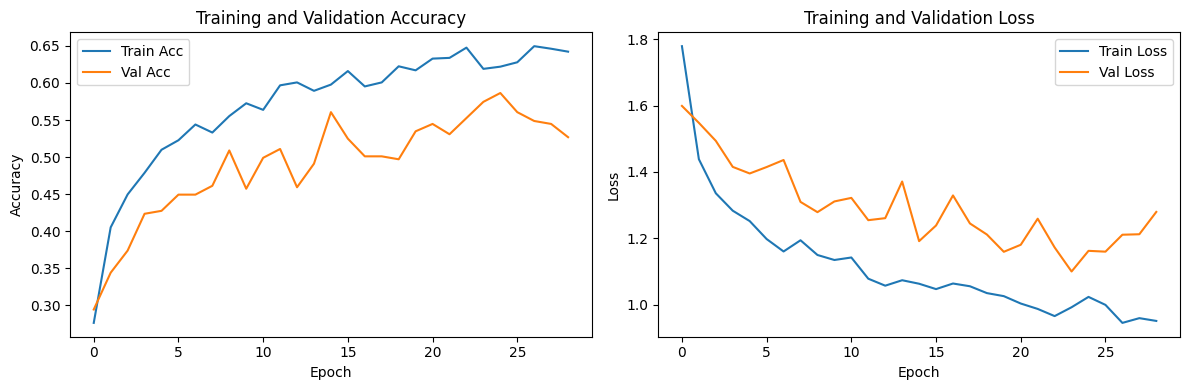

In [7]:
model.save(MODEL_SAVE_PATH)
print(f"✅ Model saved at: {MODEL_SAVE_PATH}")

# Plot Accuracy and Loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
